In [1]:
from multi_nutrient_model import ref_parameters, perturbation_dynamics, \
    perturbation_steady_state, I0,  PARAMETER_NAMES, PARAMETER_DESCRIPTIONS, steady_state
import numpy as np

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate for the K/P models
colors_AIRKO = ['grey', 'lightcoral']
colors_MIRKO = ['grey', 'steelblue']


In [3]:
p = ref_parameters( KI_F = 0.2 )
X0 = steady_state(1,p=p)


In [4]:
import warnings
warnings.filterwarnings('ignore')

def basins_of_attraction(p, X0, var_1, var_2, r_min = 0.0, r_max = 2, n=7, tmax=120, t_n= 200, threshold=1000):
    """
    Compute the basins of attraction for the model.
    
    Parameters
    ----------
    p : dict
        Model parameters.
    X0 : np.ndarray
        Initial condition.
    vars : list, optional
        Variables to plot, by default [0, 1].
    r_min : float, optional
        Minimum perturbation radius, by default 0.1.
    r_max : float, optional
        Maximum perturbation radius, by default 10.
    tmax : int, optional
        Maximum time for simulation, by default 1000.
    n : int, optional
        Number of perturbations to test, by default 100.
    
    Returns
    -------
    results : np.ndarray
        Array of trajectories for each initial condition
    divergence_map : np.ndarray
        Boolean array indicating which initial conditions led to divergence
    divergence_info : list
        List of tuples with (i, j, r1_val, r2_val) for divergent trajectories
    """

    # Make a grid of initial conditions where X0 is perturbed in the directions of var_1 and var_2.
    # Enumerate all combinations of perturbations in var_1 and var_2.
    r = np.linspace(r_min, r_max, n)
    # Meshgrid to create a grid of perturbations.
    r1, r2 = np.meshgrid(r, r)
    # Create a grid of initial conditions by perturbing X0 in the directions of var_1 and var_2.
    results = np.zeros((n, n, len(X0), t_n))
    divergence_info = []  # track faulty integrations and extreme cases
    divergence_map = None

    # Time array for the simulation.
    time = np.linspace(0, tmax, t_n)
    
    print(f"Starting basin analysis with {n}x{n} grid...")
    
    for i in range(n):
        for j in range(n):
            X0_perturbed = X0.copy()
            X0_perturbed[var_1] *= r1[i,j]
            X0_perturbed[var_2] *= r2[i,j]
            
            # Simulate the dynamics from the perturbed initial condition.
            X = perturbation_dynamics(time, 1.0, X0=X0_perturbed, p=p)
            X_values = X[0].T.values[:-1]
            # Scale the insulin by the I0 
            X_values[4,:] /= I0

            # check non-finite or extreme values
            results[i,j,:,:] = X_values
            if not np.all(np.isfinite(X_values)):
                divergence_info.append((i, j, r1[i,j], r2[i,j], 'nan'))
            elif threshold is not None and np.max(np.abs(X_values)) > threshold:
                divergence_info.append((i, j, r1[i,j], r2[i,j], 'exceed'))
   
    # build divergence map if threshold provided
    if threshold is not None:
        divergence_map = np.zeros((n, n), dtype=bool)
        for (i,j,_,_,kind) in divergence_info:
            divergence_map[i,j] = True

    return results, divergence_map, divergence_info



In [5]:
# Numerate all combinations of perturbations in var_1 and var_2 in i = 0,1,2,3
# i = 0: lactate, i = 1: glucose, i = 2: fatty acids, i = 3: ketone bodies, i = 4: insulin
from itertools import combinations
var_names = ["Lactate","Glucose","Fatty Acids","Ketone Bodies", 'Insulin']
pairs = list(combinations(range(len(var_names)), 2))
# Compute basins for each pair
basins_results = {}
divergence_maps = {}
divergence_infos = {}
for i, j in pairs:
    results, div_map, div_info = basins_of_attraction(p, X0, i, j)
    basins_results[(i, j)] = results
    # divergence_maps[(i, j)] = div_map
    # divergence_infos[(i, j)] = div_info

# Example access:
# basins_results[(1,2)] for Glucose vs Fatty Acids

Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...
Starting basin analysis with 7x7 grid...


In [6]:
def plot_trajectories(results, X0, var_1, var_2, ax=None, color='grey', alpha=0.7):
    """
    Plot trajectories from all boundary points of the perturbation grid.

    Parameters
    ----------
    results : np.ndarray
        Array of trajectories for each initial condition.
    X0 : np.ndarray
        Steady state condition.
    var_1 : int
        Index of the first variable to plot.
    var_2 : int
        Index of the second variable to plot.
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, by default None.
    color : str, optional
        Line and arrow color, by default 'grey'.
    alpha : float, optional
        Line and arrow transparency, by default 0.7.

    Returns
    -------
    None
    """

    n = results.shape[0]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Determine axis limits from starting points
    start_x = results[:, :, var_1, 0].flatten()
    start_y = results[:, :, var_2, 0].flatten()
    min_x, max_x = start_x.min(), start_x.max()
    min_y, max_y = start_y.min(), start_y.max()

    # Plot all boundary trajectories in grey with arrows
    arrow_counter = 0
    arrow_placed = 0
    max_arrows = 4
    for i in range(n):
        for j in range(n):
            if i == 0 or i == n-1 or j == 0 or j == n-1:
                arrow_counter += 1
                trajectory = results[i, j, :, :]
                x = trajectory[var_1, :]
                y = trajectory[var_2, :]
                ax.plot(x, y, color=color, alpha=alpha, linewidth=1.5)

    if var_1 == 4:
        ax.scatter(X0[var_1]/I0, X0[var_2], color='black', s=25, zorder=5)
    elif var_2 == 4:
        ax.scatter(X0[var_1], X0[var_2]/I0, color='black', s=25, zorder=5)
    else:           
        ax.scatter(X0[var_1], X0[var_2], color='black', s=25, zorder=5)

    # Limit axes to starting-point range
    ax.set_xlim(0.0 , max_x )
    ax.set_ylim(0.0 , max_y )

    return ax

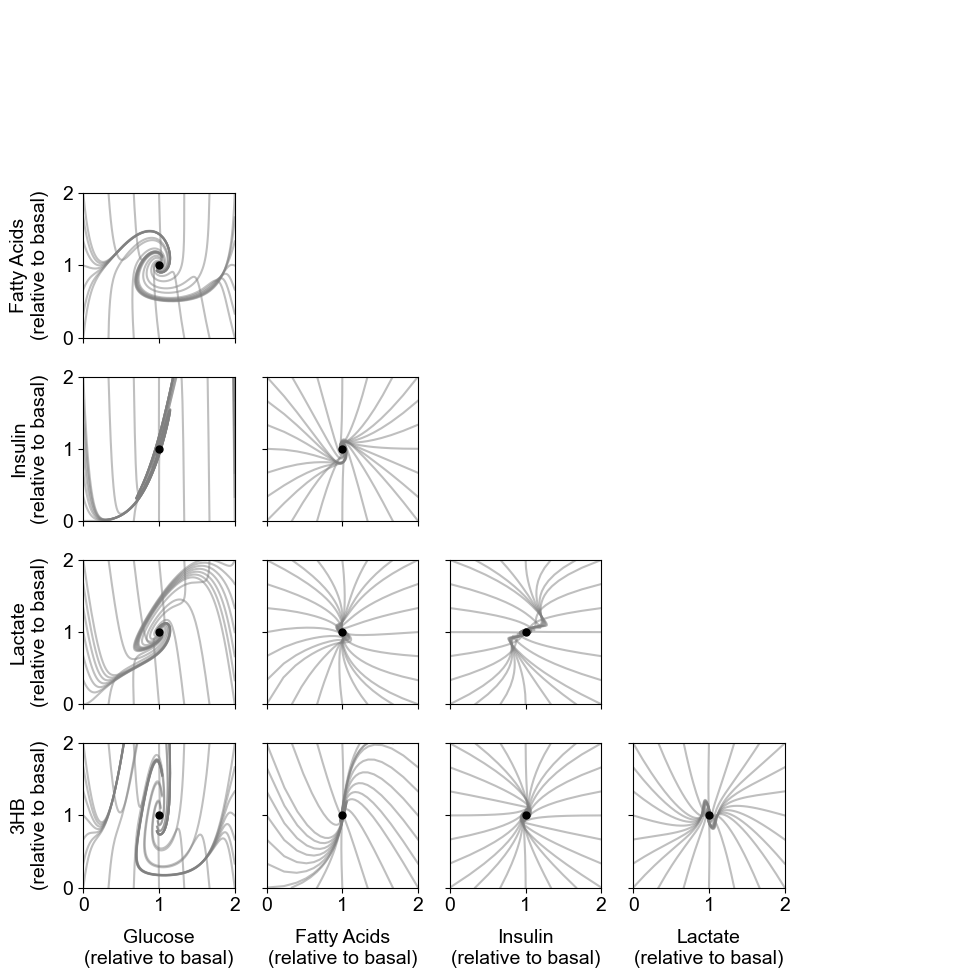

In [7]:
# Custom ordering for the triangular plot
import matplotlib.pyplot as plt
# Define the plotting order: map variable names to original indices

# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

order_map = {
    'Glucose': 1,
    'Fatty Acids': 2,
    'Insulin': 4,
    'Lactate': 0,
    '3HB': 3
}

display_vars = ['Glucose', 'Fatty Acids', 'Insulin', 'Lactate', '3HB']

# Extract ordered names and indices
indices = [order_map[name] for name in display_vars]
n = len(indices)
# Create full n×n grid and show only lower triangle
fig, axs = plt.subplots(n, n, figsize=(2*n, 2*n), sharex='col', sharey='row')
for ri, orig_i in enumerate(indices):
    for cj, orig_j in enumerate(indices):
        ax = axs[ri, cj]
        if ri > cj:
            # fetch basin results regardless of key order
            key_direct = (orig_j, orig_i)
            key_swap = (orig_i, orig_j)
            if key_direct in basins_results:
                results = basins_results[key_direct]
            elif key_swap in basins_results:
                # swap grid axes so first dim matches orig_j
                results = basins_results[key_swap].swapaxes(0, 1)
            else:
                continue
            plot_trajectories(results, X0, orig_j, orig_i, ax=ax, color='grey', alpha=0.5)

            # Add label variable\n(relative to steady state)
            if cj == 0:
                ax.set_ylabel(f"{display_vars[ri]}\n(relative to basal)", labelpad=10)
            if ri == n - 1:
                ax.set_xlabel(f"{display_vars[cj]}\n(relative to basal)", labelpad=10)
        else:
            ax.axis('off')
fig.tight_layout()



# Save as an svg in out
fig.savefig('./output/basins_of_attraction.svg', format='svg', bbox_inches='tight', )

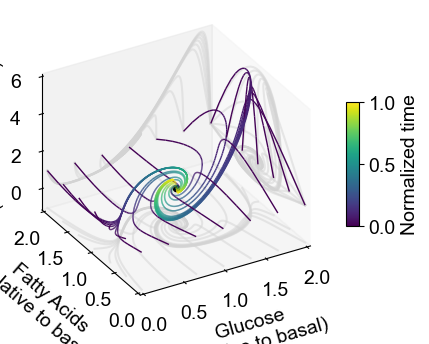

In [8]:
# 3D trajectory line plot with time-based color mapping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

angle_z = -120

# Retrieve Glucose vs Fatty Acids basins
results_gf = basins_results[(1, 2)]
n = results_gf.shape[0]

# Determine number of time points
t_steps = results_gf.shape[-1]
times = np.linspace(0, 1, t_steps)

fig = plt.figure(figsize=(5, 8))
ax = fig.add_subplot(111, projection='3d')
# Use orthographic projection and equal aspect to keep axes straight
try:
    ax.set_proj_type('ortho')
except AttributeError:
    pass
ax.set_box_aspect((1, 1, 0.8))

# Create a colormap
cmap = plt.get_cmap('viridis')

# Plot each boundary trajectory as colored line segments
for i in range(n):
    for j in range(n):
        if i in (0, n-1) or j in (0, n-1):
            traj = results_gf[i, j, :, :]
            x, y, z = traj[1, :], traj[2, :], traj[4, :]
            # build segments for Line3DCollection
            points = np.array([x, y, z]).T.reshape(-1, 1, 3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0,1))
            lc.set_array(times)
            lc.set_linewidth(1)
            ax.add_collection3d(lc)

            # projections onto background planes
            ax.plot(x, y, zs=-1, zdir='z', color='lightgrey', linestyle='-', alpha=0.5, zorder=0)
            ax.plot(x, z, zs=2, zdir='y', color='lightgrey', linestyle='-', alpha=0.5, zorder=0)
            ax.plot(y, z, zs=2, zdir='x', color='lightgrey', linestyle='-', alpha=0.5, zorder=0)

# Mark steady state
ss = np.array([X0[1], X0[2], X0[4]/I0])
ax.scatter(ss[0], ss[1], ss[2], color='black', s=20, label='Steady State')

# Label axes
ax.set_xlabel('Glucose\n(relative to basal)',labelpad=12)
ax.set_ylabel('Fatty Acids\n(relative to basal)', labelpad=12)
ax.set_zlabel('Insulin\n(relative to basal)',)

# Set axis limits and rotation
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(-1, 6)
ax.view_init(elev=30, azim=angle_z)
ax.grid(False)


# Add colorbar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0,1))
mappable.set_array(times)
cbar = fig.colorbar(mappable, shrink=0.2, aspect=10)
# Set colorbar label on top
cbar.set_label('Normalized time')

# Adjust 
plt.savefig('./output/basins_of_attraction_3d.svg', format='svg', bbox_inches='tight')

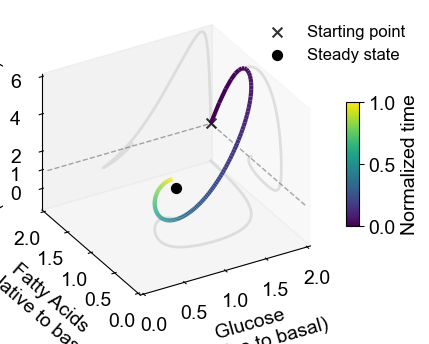

In [9]:
# 3D trajectory line plot with a single trajectory
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

angle_z = -120

# Retrieve Glucose vs Fatty Acids basins
results_gf = basins_results[(1, 2)]
n = results_gf.shape[0]

# Select a single trajectory from the boundary (e.g., corner trajectory)
i_select, j_select = n-1, n-1  # Top-right corner of the grid

# Determine number of time points
t_steps = results_gf.shape[-1]
times = np.linspace(0, 1, t_steps)

fig = plt.figure(figsize=(5, 8))
ax = fig.add_subplot(111, projection='3d')
# Use orthographic projection and equal aspect to keep axes straight
try:
    ax.set_proj_type('ortho')
except AttributeError:
    pass
ax.set_box_aspect((1, 1, 0.8))

# Create a colormap
cmap = plt.get_cmap('viridis')

# Plot the single selected trajectory
traj = results_gf[i_select, j_select, :, :]
x, y, z = traj[1, :], traj[2, :], traj[4, :]

# Build segments for Line3DCollection with time-based coloring
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0,1))
lc.set_array(times[:-1])  # Use times for coloring
lc.set_linewidth(3)
ax.add_collection3d(lc)

# Add projections onto background planes
ax.plot(x, y, zs=-1, zdir='z', color='lightgrey', linestyle='-', alpha=0.7, linewidth=2, zorder=0)
ax.plot(x, z, zs=2, zdir='y', color='lightgrey', linestyle='-', alpha=0.7, linewidth=2, zorder=0)
ax.plot(y, z, zs=2, zdir='x', color='lightgrey', linestyle='-', alpha=0.7, linewidth=2, zorder=0)

# Plot a horizontal lines z=1 in the xz and yz planes
# from 0 -2 
s = np.linspace(0, 2, 100)
ax.plot(s, np.ones_like(s), zs=2, zdir='y', color='grey', linestyle='--', alpha=0.7, linewidth=1, zorder=0)
ax.plot(s, np.ones_like(s), zs=2, zdir='x', color='grey', linestyle='--', alpha=0.7, linewidth=1, zorder=0)


# Mark starting point and steady state
ax.scatter(x[0], y[0], z[0], color='black',marker='x', s=50, label='Starting point', alpha=0.8)
ss = np.array([X0[1], X0[2], X0[4]/I0])
ax.scatter(ss[0], ss[1], ss[2], color='black', s=50, label='Steady state')

# Label axes
ax.set_xlabel('Glucose\n(relative to basal)',labelpad=12)
ax.set_ylabel('Fatty Acids\n(relative to basal)', labelpad=12)
ax.set_zlabel('Insulin\n(relative to basal)')

# Set axis limits and rotation
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(-1, 6)
ax.set_zticks([0, 1, 2, 4, 6])
ax.view_init(elev=30, azim=angle_z)
ax.grid(False)
ax.legend()

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0,1))
mappable.set_array(times)
cbar = fig.colorbar(mappable, shrink=0.2, aspect=10)
cbar.set_label('Normalized time')

# Move legend to upper right corner
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12, frameon=False)

plt.savefig('./output/single_trajectory_3d.svg', format='svg', bbox_inches='tight')
plt.show()